### Cena 2
- Simulação com a mini câmara com material de 2.5cm de espessura
- Aplicando impedância de superfície calculada apartir da formulação da ISO 354.


### Importando bibliotecas


In [1]:
# Importando bibliotecas

import femder as fd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pickle
from femder.FEM_3D import  p2SPL

Default Plotly renderer: jupyterlab


### Importando resultados experimentais
- velocidade de volume
- coef. absorção ISO 354
- sinal medido nos receptores
- respostas impulsivas

In [2]:
import scipy.io as sio

q = sio.loadmat(r'G:\\Meu Drive\\TCC\\Simulacao_computacional\\Qi.mat')
# sorted(q.keys())
q = q['Qi'] # até 600Hz

as_medido = sio.loadmat(r'G:\\Meu Drive\\TCC\\Experimental\\com_material\\espessura_maior\\a_s.mat')
# sorted(as_medido.keys())

R_comMat = sio.loadmat(r'G:\\Meu Drive\\TCC\\Experimental\\com_material\\espessura_maior\\pts_freq.mat')
# sorted(R_semMat.keys())

RI_comMat = sio.loadmat(r'G:\\Meu Drive\\TCC\\Experimental\\com_material\\espessura_maior\\RIs.mat')



In [31]:
sorted(RI_comMat.keys())

['RIs_sz', '__globals__', '__header__', '__version__']

### Importar geometria, inicializando as classes dos dados de entrada da simulação

In [3]:
# Importar geometria, inicializando as classes dos dados de entrada da simulação

path_to_geo = "G:\Meu Drive\TCC\Simulacao_computacional\codes\geo\minicamara_menor\maisEspesso_semVol.iges"

AP = fd.AirProperties(c0 = 343)
fmax = 2000 #2000
fmin = 150
AC = fd.AlgControls(AP,fmin,fmax,0.5)
S = fd.Source("spherical")
S.coord = np.array([[1.222,0.15,0.2]])
S.q = np.array(q)
#S.q = np.array([0.001])
R = fd.Receiver()
#R.coord = np.array([[0.33,0.23,0.21],[0.38,0.93,0.21],[0.92,0.95,0.21]]) 
R.coord = np.array([[1.057,0.695,0.282],[0.425,0.925,0.235],
                    [0.409,0.406,0.235],[0.336,0.677,0.282],
                    [0.685,0.965,0.235],[0.661,0.30,0.235]])
 

In [ ]:
# Recuperando a impedância de superficie das paredes da minicamara apartir do coef. de abs medido pela ISO 354

from sea.sea.materials import Material as mat

#with open(r"G:\Meu Drive\TCC\codes\dados-pickle\admitance_minicamara1.pkl","rb") as arquivo:
  #sup_admittance = pickle.load(arquivo)
  
sup = mat(third_octave_bands_statistical_alpha=[0.0912, 0.0813, 0.1370, 0.3288, 0.4946, 0.8103, 0.5480, 0.9666], third_octave_bands = [200, 250, 315, 400, 500, 630, 800, 1000], freq_vec=AC.freq)
sup.impedance_from_alpha(absorber_type="soft porous")
sup_admittance = sup.admittance # Admitancia normalizada
sup_surface_impedance = sup.surface_impedance # Impedancia não normalizada 

In [10]:
# with open('G:\Meu Drive\TCC\Simulacao_computacional\codes\dados-pickle\Cena 2\sup_admittance150-2k.pkl', "wb") as arquivo:
#     pickle.dump(sup, arquivo)

# import pickle
# with open("G:\Meu Drive\TCC\Simulacao_computacional\codes\dados-pickle\cena1\sup_admittance150-2K.pkl","rb") as arquivo:
#   sup_minicam = pickle.load(arquivo)

# with open("G:\Meu Drive\TCC\Simulacao_computacional\codes\dados-pickle\Cena 2\sup_admittance150-2k.pkl","rb") as arquivo:
#   sup_mat = pickle.load(arquivo)

In [4]:
# Boundary Conditions
BC = fd.BC(AC,AP) #[2,3,4,5,6,7]
#BC.normalized_admittance(6,sup.admittance)
BC.delany(6,RF=12100, d=0.025, model='miki')
BC.normalized_admittance([2,3,4,5,7,8,9,10,11,12],0.004)

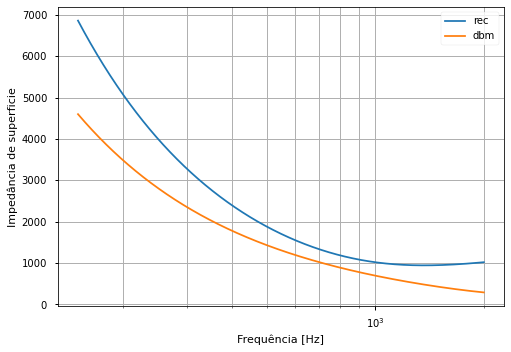

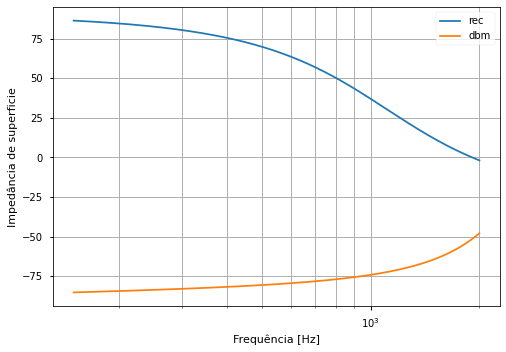

In [30]:
plt.semilogx(AC.freq, abs(1/As_rec), label='rec')
plt.semilogx(AC.freq, abs(1/As_dbm), label='dbm')
#plt.xlim(20, 10000)
#plt.ylim(0, 100)
plt.xlabel('Frequência [Hz]')
plt.ylabel('Impedância de superficie')
plt.legend()
plt.grid(True,which="both")
#plt.savefig('L_fixo.png')
plt.show()

plt.semilogx(AC.freq, np.angle(1/As_rec,deg=True), label='rec')
plt.semilogx(AC.freq, np.angle(1/As_dbm,deg=True), label='dbm')
#plt.xlim(20, 10000)
#plt.ylim(0, 100)
plt.xlabel('Frequência [Hz]')
plt.ylabel('Impedância de superficie')
plt.legend()
plt.grid(True,which="both")
#plt.savefig('L_fixo.png')
plt.show()

### Verificação da equivalência entre os alphas (in x recuperado)

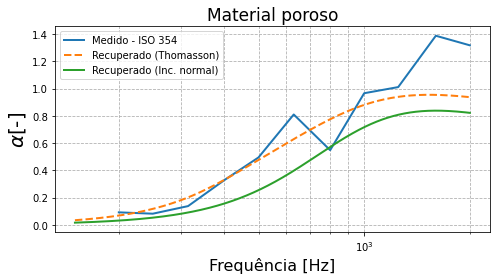

In [18]:
# Verificação da equivalência entre os coefs 
## () analisar recuperando com alphas em bando de terç de oitava
## () calcular erro entre os coefs
z_ar = AP.c0*AP.rho0
#Zs = sup.surface_impedance/z_ar
Zs = BC.mu[6]*z_ar
Reflexao = (Zs - 1) / (Zs + 1)
Absorcao = 1 - (np.abs(Reflexao) ** 2)  # 1 - |R|²
plt.figure(figsize=(7,4))
plt.semilogx(as_medido['f'][:11], as_medido['a_s'][:11], linestyle='-', label = 'Medido - ISO 354',linewidth=2)
plt.semilogx(AC.freq, sup.statistical_alpha,label='Recuperado (Thomasson)', linestyle='--', linewidth=2)
plt.semilogx(AC.freq, Absorcao, linestyle='-', label = 'Recuperado (Inc. normal)',linewidth=2)
plt.grid(linestyle = '--', which='both')
plt.legend(loc='best')
plt.title('Material poroso', fontsize=17)
plt.xlabel('Frequência [Hz]', fontsize=16)
plt.ylabel(r'$\alpha$[-]', fontsize=20)
#plt.xticks([20,40,60,80,100,120,160,200],[20,40,60,80,100,120,160,200]);
#plt.xticks([200,250,315,400,500,630,800,1000,1250,1600,2000],[200,250,315,400,500,630,800,1000,1250,1600,2000])
plt.tight_layout()
#plt.ylim((0,0.4))
# plt.xlim((200,2000))
#plt.savefig("/content/drive/MyDrive/TCC/Documento/abs_teto.pdf")
plt.show()

### Geração da malha, inicializando a classe FEM3D com os dados de entrada e o plote da geomeria com a malha 2D


In [5]:
grid = fd.GridImport3D(AP,path_to_geo,S,R,fmax = fmax,num_freq=6,scale=1000,order=1,load_method='meshio')
obj = fd.FEM3D(grid,S,R,AP,AC,BC)
obj.plot_problem(renderer='browser',saveFig=False,camera_angles=['diagonal_front'],extension='png')

### Cálculo das pressões com o método de elementos finitos

In [24]:
obj.compute() # debug e comparar vel const e dpendente freqa
obj.evaluate(R)

FEM | Assembling surface matrix: 100%|█████████████████████████| 11/11 [00:00<00:00, 44.22it/s]
100%|██████████| 3701/3701 [3:18:54<00:00,  3.22s/it]  


Time taken: 199.14248484373093 min


array([[ 3.05149768e-04+1.1034293j , -6.77595260e-02-1.31373081j,
        -6.59810541e-02-1.45552957j, -6.60088231e-02-1.57116863j,
        -3.85808891e-02-0.44119508j, -4.64642295e-02-0.32383331j],
       [ 1.17139821e-02+1.03050651j, -8.09616462e-02-1.26488076j,
        -8.36364321e-02-1.39588567j, -8.33821387e-02-1.50436099j,
        -4.22588600e-02-0.43363818j, -5.22850908e-02-0.32876987j],
       [ 2.09160651e-02+0.96421854j, -9.27701228e-02-1.22113377j,
        -9.94237727e-02-1.34391155j, -9.87444751e-02-1.44507495j,
        -4.58146725e-02-0.42679766j, -5.81432123e-02-0.33516361j],
       ...,
       [-4.04909010e-01+0.20918921j, -4.13471403e-01-0.04752792j,
         1.01371247e-01-0.49246287j,  2.33267260e-01-0.04029183j,
        -4.77150602e-01+0.38455622j, -4.32507024e-01+0.3681899j ],
       [-3.83287260e-01+0.20708271j, -4.21499542e-01-0.03641785j,
         6.41556119e-02-0.51051121j,  2.12041397e-01-0.02630935j,
        -3.77442444e-01+0.42345904j, -3.94788326e-01+0.35714

In [6]:
# Salva var
# with open("G:\\Meu Drive\\TCC\\Simulacao_computacional\\minicamara-90mm\\minicamara_comMat\\espessura2_5cm\\Zs_cte0_004_DBM_obj_Minicamara_150_2000_0_5.pkl", "wb") as arquivo:
#     pickle.dump(obj, arquivo)

import pickle
with open("G:\\Meu Drive\\TCC\\Simulacao_computacional\\minicamara-90mm\\minicamara_comMat\\espessura2_5cm\\Zs_cte0_004_DBM_obj_Minicamara_150_2000_0_5.pkl","rb") as arquivo:
  obj = pickle.load(arquivo)


In [7]:
obj.evaluate(R) 

0.02354257794065182
0.009310877691947725
0.014177817947200294
0.017949423027220014
0.009421868784851123
0.013414512197153321


array([[ 3.05149768e-04+1.1034293j , -6.77595260e-02-1.31373081j,
        -6.59810541e-02-1.45552957j, -6.60088231e-02-1.57116863j,
        -3.85808891e-02-0.44119508j, -4.64642295e-02-0.32383331j],
       [ 1.17139821e-02+1.03050651j, -8.09616462e-02-1.26488076j,
        -8.36364321e-02-1.39588567j, -8.33821387e-02-1.50436099j,
        -4.22588600e-02-0.43363818j, -5.22850908e-02-0.32876987j],
       [ 2.09160651e-02+0.96421854j, -9.27701228e-02-1.22113377j,
        -9.94237727e-02-1.34391155j, -9.87444751e-02-1.44507495j,
        -4.58146725e-02-0.42679766j, -5.81432123e-02-0.33516361j],
       ...,
       [-4.04909010e-01+0.20918921j, -4.13471403e-01-0.04752792j,
         1.01371247e-01-0.49246287j,  2.33267260e-01-0.04029183j,
        -4.77150602e-01+0.38455622j, -4.32507024e-01+0.3681899j ],
       [-3.83287260e-01+0.20708271j, -4.21499542e-01-0.03641785j,
         6.41556119e-02-0.51051121j,  2.12041397e-01-0.02630935j,
        -3.77442444e-01+0.42345904j, -3.94788326e-01+0.35714

### Plote dos NPS resultantes em cada receptor

0.02354257794065182
0.009310877691947725
0.014177817947200294
0.017949423027220014
0.009421868784851123
0.013414512197153321


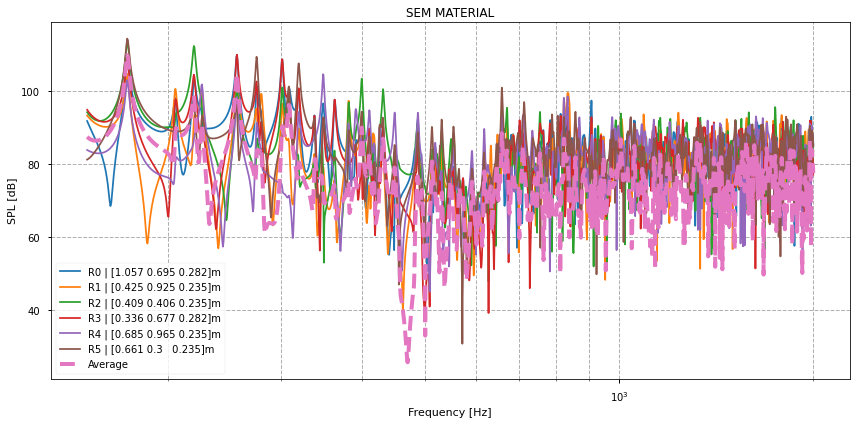

In [4]:
R = fd.Receiver()
#R.coord = np.array([[0.33,0.23,0.21],[0.38,0.93,0.21],[0.92,0.95,0.21]]) 
R.coord = np.array([[1.057,0.695,0.282],[0.425,0.925,0.235],
                    [0.409,0.406,0.235],[0.336,0.677,0.282],
                    [0.685,0.965,0.235],[0.661,0.30,0.235]])
obj.evaluate(R)
plt.style.use('seaborn-notebook')
plt.figure(figsize=(12,6))

if len(obj.R.coord)==1:
  plt.semilogx(obj.freq, p2SPL(obj.pR), linestyle='-', label=f'R | {obj.R.coord[0]}m')
else:
  for i in range(len(obj.R.coord)):
      plt.semilogx(obj.freq, p2SPL(obj.pR[:,i]), linestyle='-', label=f'R{i} | {obj.R.coord[i,:]}m')

if len(obj.R.coord) > 1:
  pR_med = np.mean(obj.pR,axis=1)
  plt.semilogx(obj.freq, p2SPL(pR_med), linestyle='--', label='Average', linewidth=4)
plt.title('SEM MATERIAL')
plt.grid(linestyle = '--', which='both')
plt.legend(loc='best')
plt.xlabel('Frequency [Hz]')
plt.ylabel('SPL [dB]')
#plt.ylim(40,160)
#plt.xticks([20,40,60,80,100,120,160,200],[20,40,60,80,100,120,160,200]);
#plt.xticks([100,125,160,200,250,315,400,500,630,1000,1250],[100,125,160,200,250,315,400,500,630,1000,1250]);
#plt.ylim(40,160)
plt.tight_layout()
plt.show()

### Comparação NPS dos pontos medido e simulado

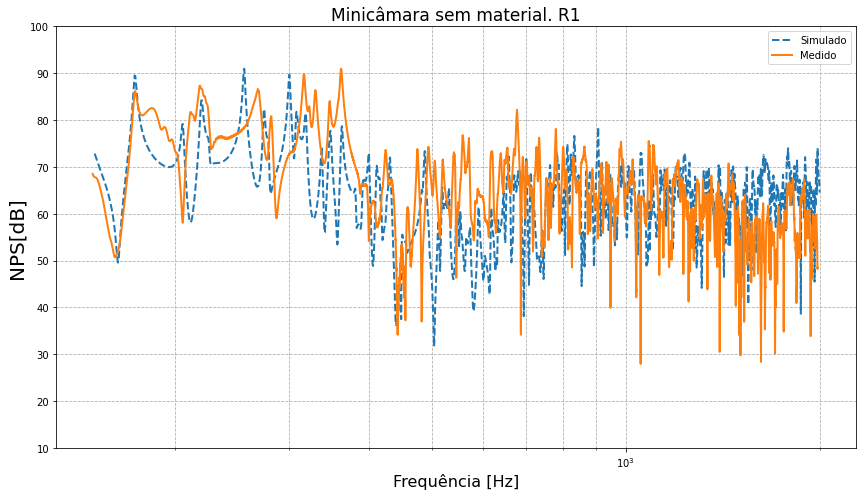

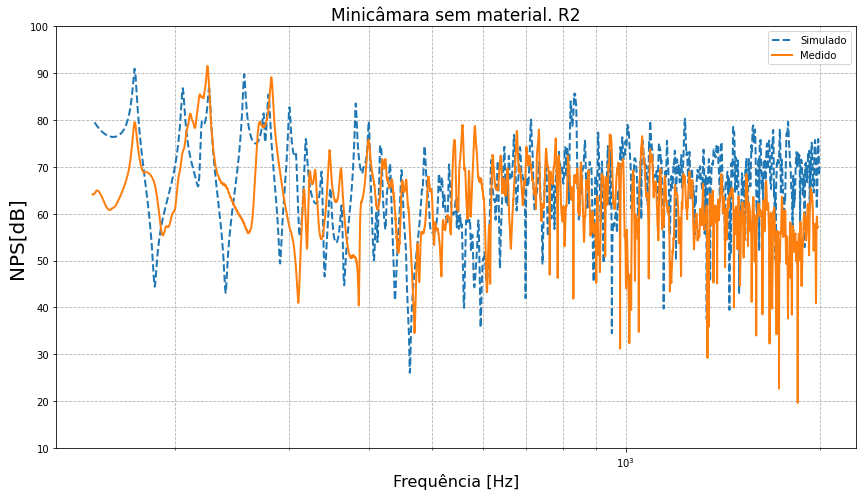

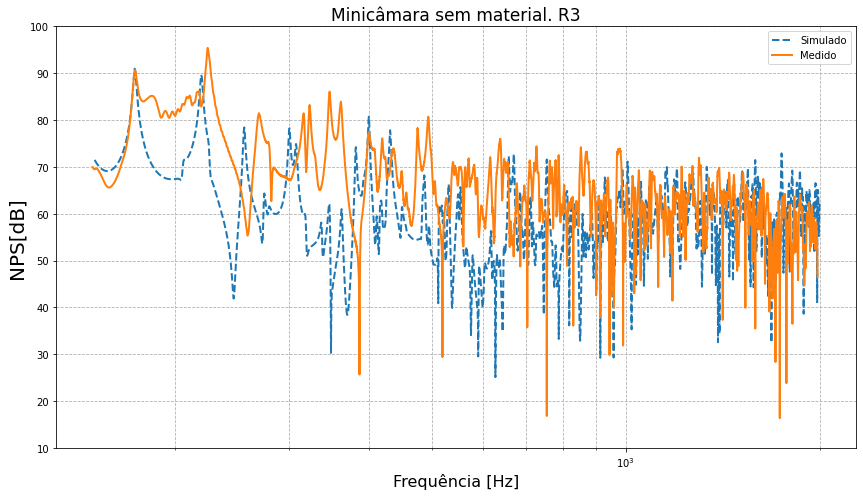

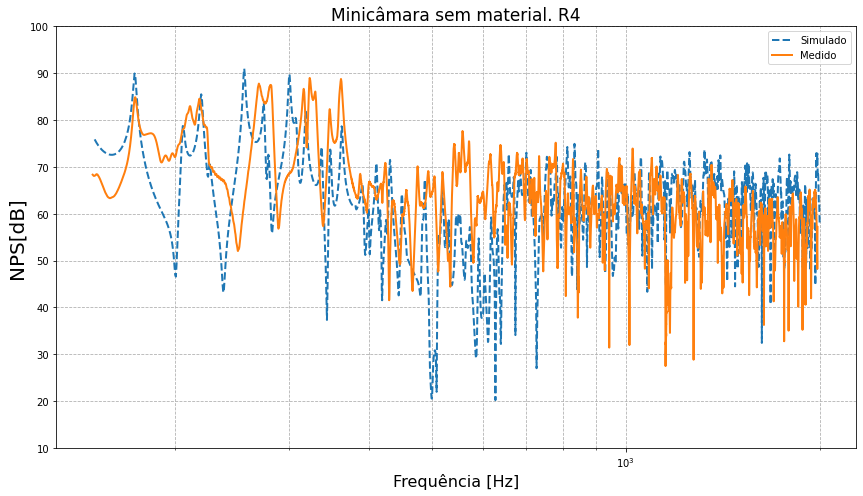

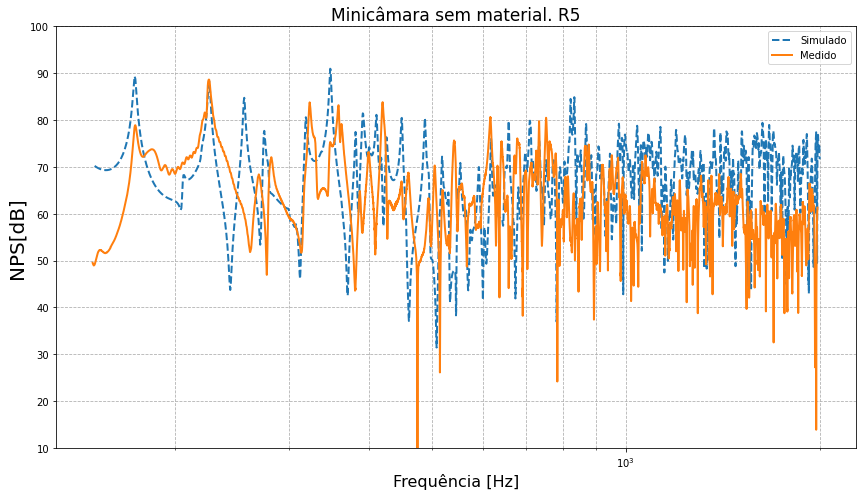

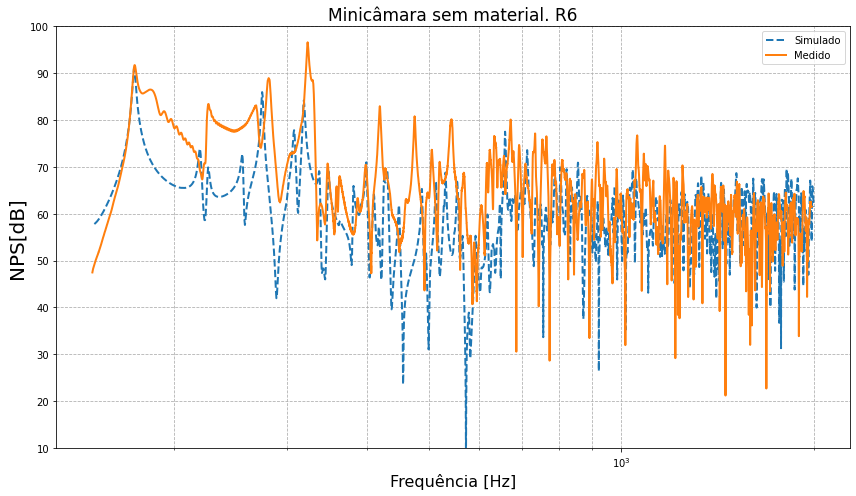

In [25]:
# Impedância de superficie recuperada pelo alpha obtido pela ISO 354
for n in range(0,6):
    plt.figure(figsize=(12,7))
    plt.semilogx(AC.freq, p2SPL(obj.pR[:,n]/max(abs(obj.pR[:,n]))),label='Simulado', linestyle='--', linewidth=2)
    plt.semilogx(R_comMat['freqVector'][1981:26401,0], p2SPL(R_comMat['pts_freq'][1981:26401,n]/max(abs(R_comMat['pts_freq'][1981:26401,0]))), linestyle='-', label = 'Medido',linewidth=2)
    plt.grid(linestyle = '--', which='both')
    plt.legend(loc='best')
    plt.title(f'Minicâmara sem material. R{n+1}', fontsize=17)
    plt.xlabel('Frequência [Hz]', fontsize=16)
    plt.ylabel(r'NPS[dB]', fontsize=20)
#plt.xticks([20,40,60,80,100,120,160,200],[20,40,60,80,100,120,160,200]);
#plt.xticks([200,250,315,400,500,630,800,1000,1250,1600,2000],[200,250,315,400,500,630,800,1000,1250,1600,2000])
    plt.tight_layout()
    plt.ylim((10,100))
# plt.xlim((200,2000))
#plt.savefig("/content/drive/MyDrive/TCC/Documento/abs_teto.pdf")
    plt.show()  

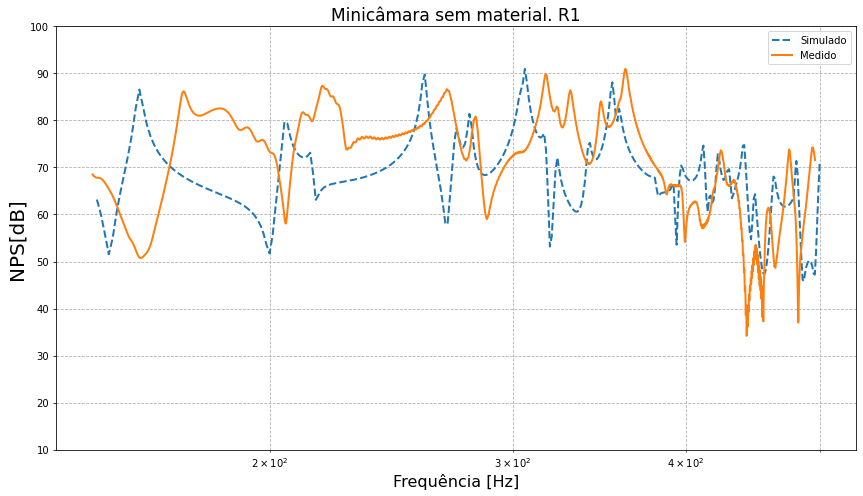

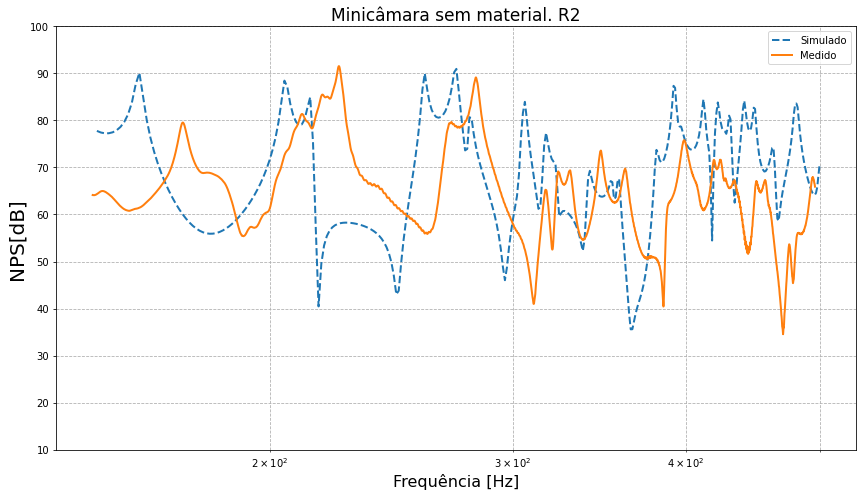

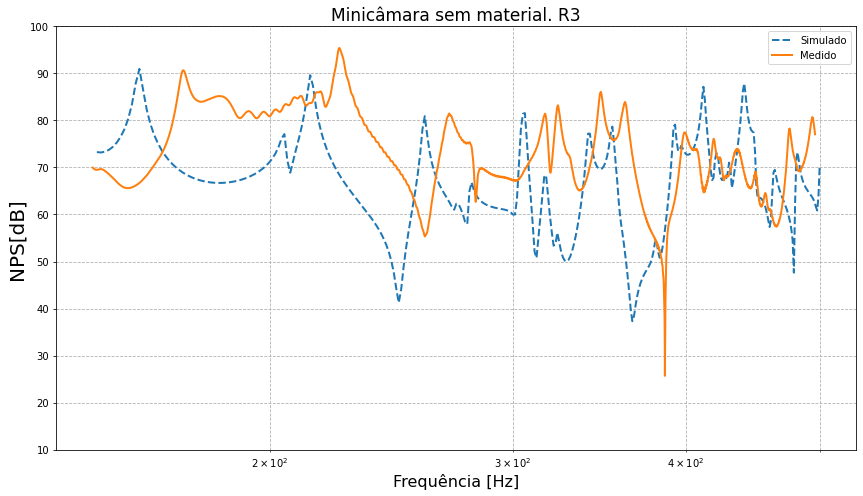

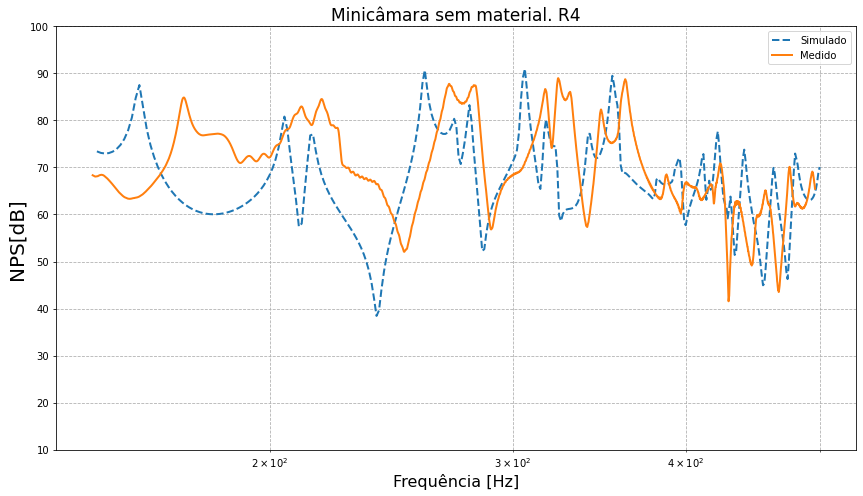

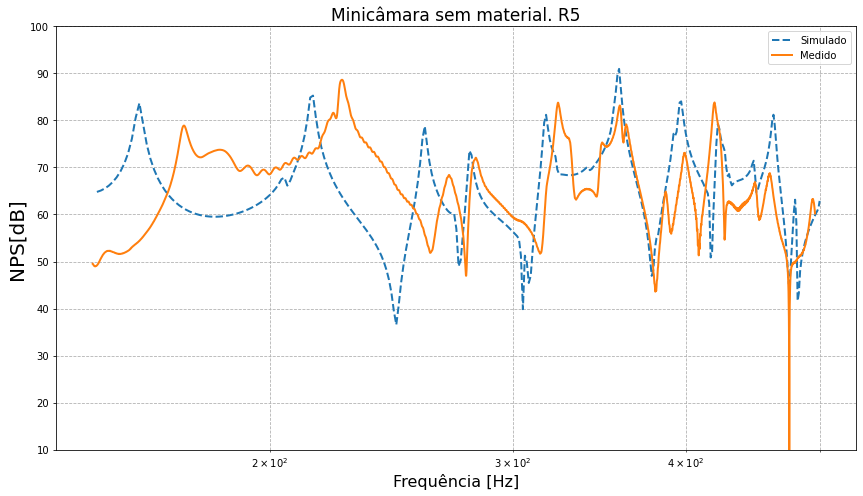

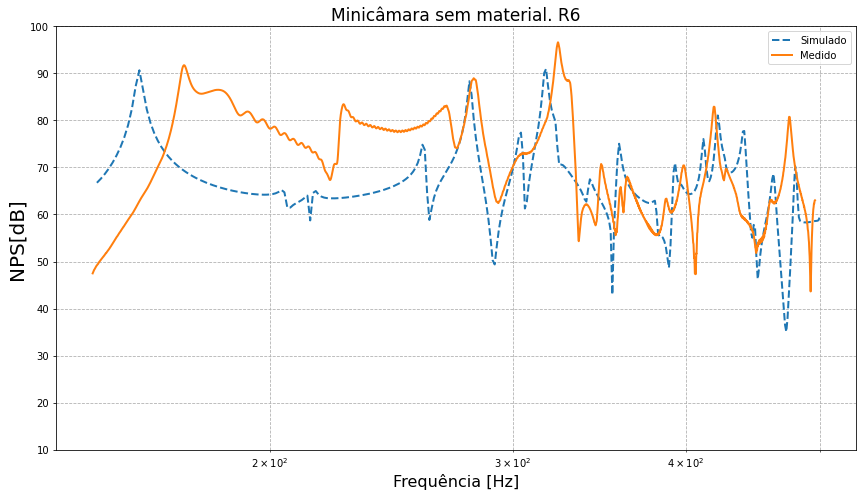

In [10]:
# Impedância de superficie recuperada pelo alpha obtido pela ISO 354
for n in range(0,6):
    plt.figure(figsize=(12,7))
    plt.semilogx(AC.freq, p2SPL(obj.pR[:,n]/max(abs(obj.pR[:,n]))),label='Simulado', linestyle='--', linewidth=2)
    plt.semilogx(R_comMat['freqVector'][1981:6600,0], p2SPL(R_comMat['pts_freq'][1981:6600,n]/max(abs(R_comMat['pts_freq'][1981:6600,0]))), linestyle='-', label = 'Medido',linewidth=2)
    plt.grid(linestyle = '--', which='both')
    plt.legend(loc='best')
    plt.title(f'Minicâmara sem material. R{n+1}', fontsize=17)
    plt.xlabel('Frequência [Hz]', fontsize=16)
    plt.ylabel(r'NPS[dB]', fontsize=20)
#plt.xticks([20,40,60,80,100,120,160,200],[20,40,60,80,100,120,160,200]);
#plt.xticks([200,250,315,400,500,630,800,1000,1250,1600,2000],[200,250,315,400,500,630,800,1000,1250,1600,2000])
    plt.tight_layout()
    plt.ylim((10,100))
# plt.xlim((200,2000))
#plt.savefig("/content/drive/MyDrive/TCC/Documento/abs_teto.pdf")
    plt.show()  

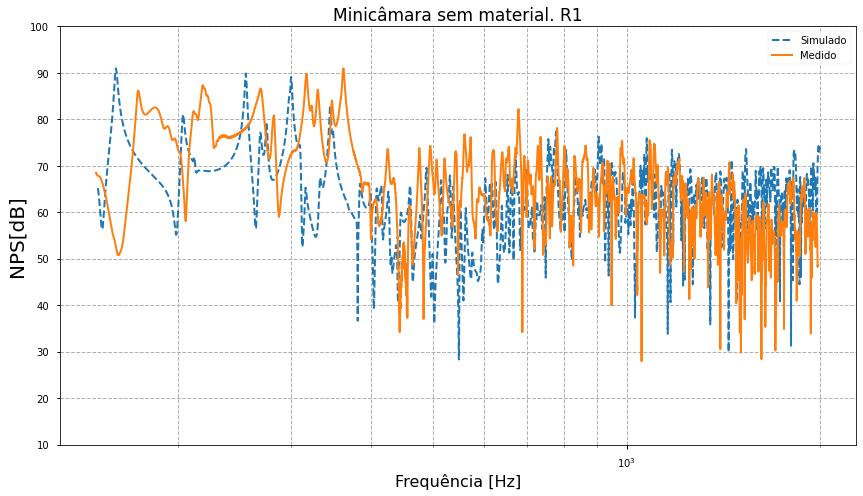

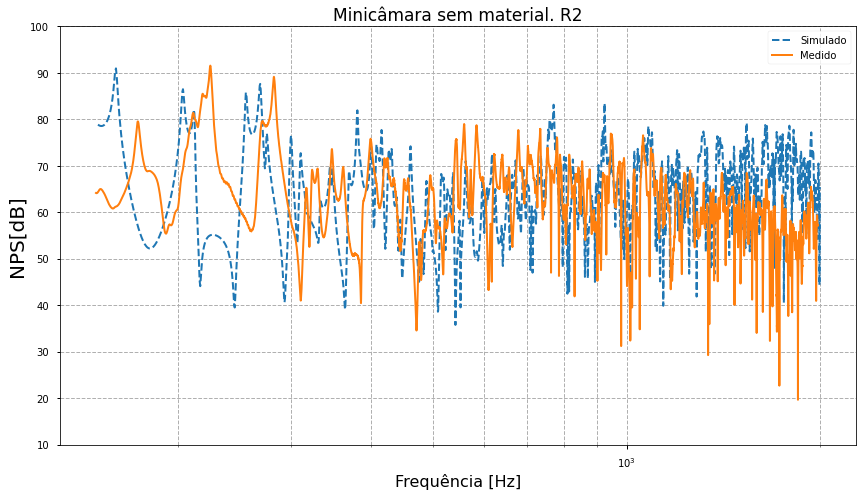

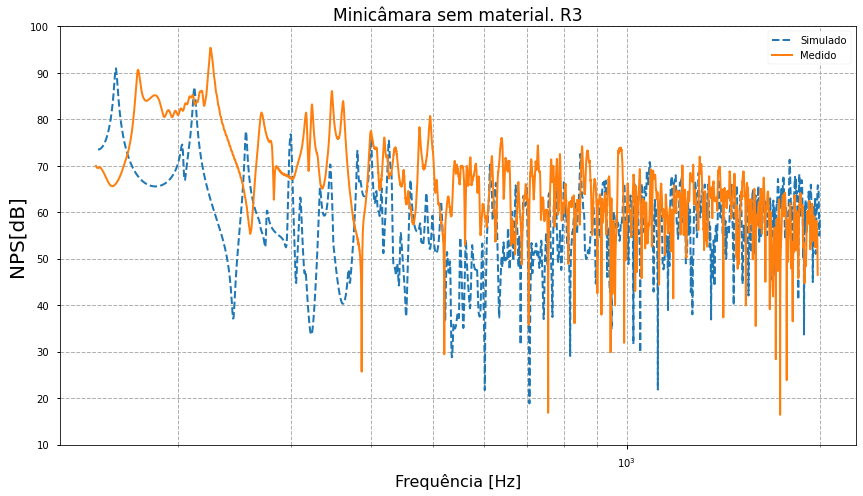

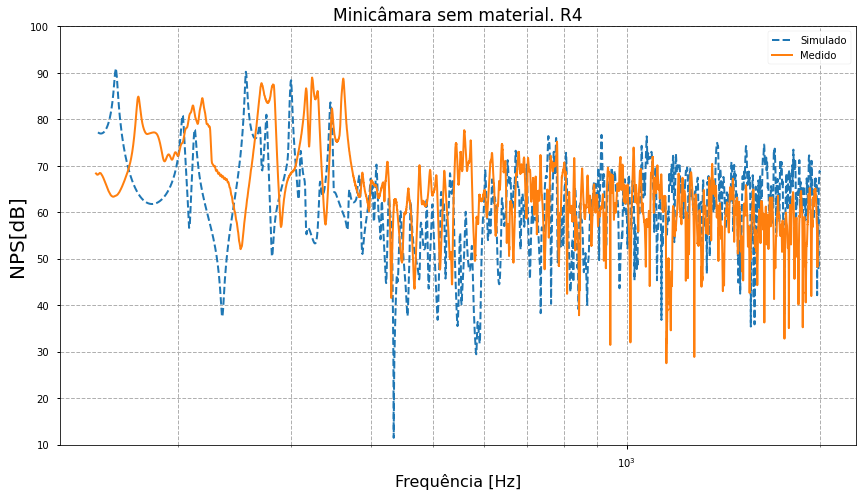

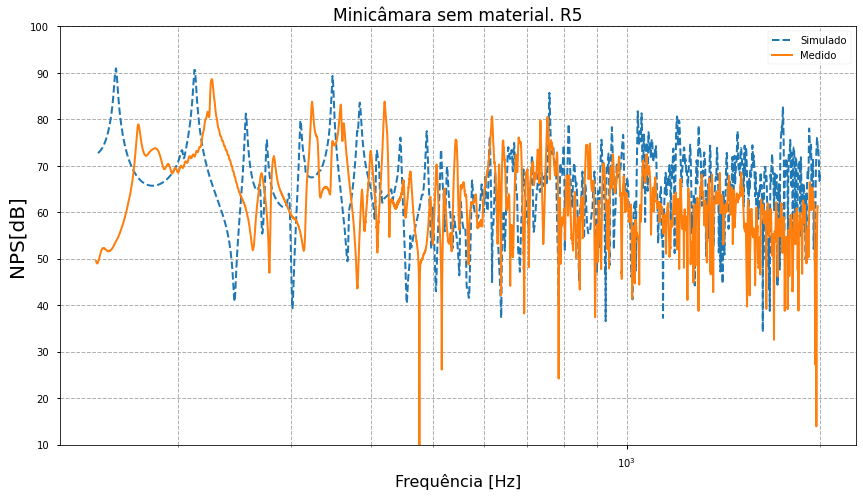

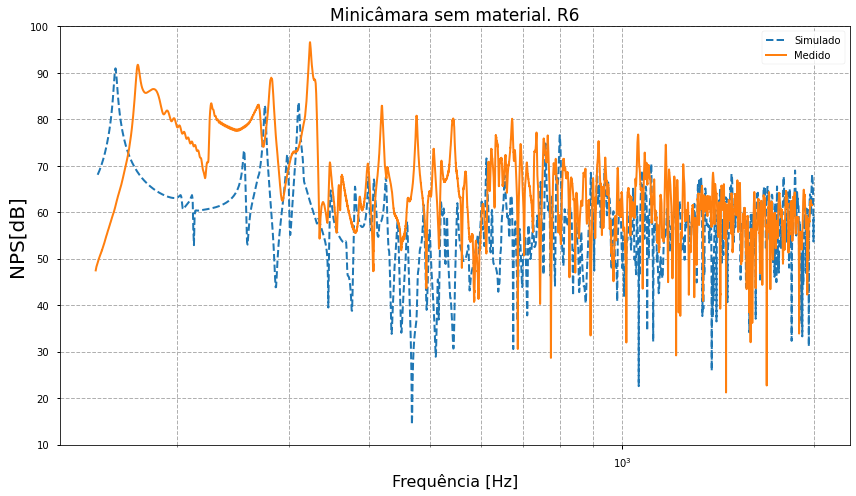

In [56]:
# Impedância de superficie recuperada pelo alpha obtido pela ISO 354
for n in range(0,6):
    plt.figure(figsize=(12,7))
    plt.semilogx(AC.freq, p2SPL(obj.pR[:,n]/max(abs(obj.pR[:,n]))),label='Simulado', linestyle='--', linewidth=2)
    plt.semilogx(R_comMat['freqVector'][1981:26401,0], p2SPL(R_comMat['pts_freq'][1981:26401,n]/max(abs(R_comMat['pts_freq'][1981:26401,0]))), linestyle='-', label = 'Medido',linewidth=2)
    plt.grid(linestyle = '--', which='both')
    plt.legend(loc='best')
    plt.title(f'Minicâmara sem material. R{n+1}', fontsize=17)
    plt.xlabel('Frequência [Hz]', fontsize=16)
    plt.ylabel(r'NPS[dB]', fontsize=20)
#plt.xticks([20,40,60,80,100,120,160,200],[20,40,60,80,100,120,160,200]);
#plt.xticks([200,250,315,400,500,630,800,1000,1250,1600,2000],[200,250,315,400,500,630,800,1000,1250,1600,2000])
    plt.tight_layout()
    plt.ylim((10,100))
# plt.xlim((200,2000))
#plt.savefig("/content/drive/MyDrive/TCC/Documento/abs_teto.pdf")
    plt.show()  

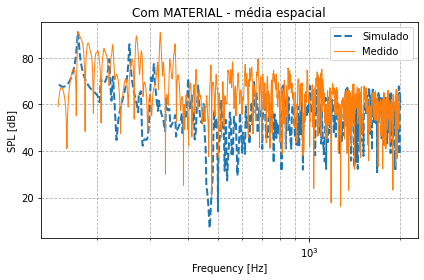

In [26]:
plt.title('Com MATERIAL - média espacial')
pR_med = np.mean(obj.pR,axis=1) # R_semMat['R_semMatfreq'][2641:7921,n]
R_med = np.mean(R_comMat['pts_freq'][1981:26401],axis=1)
plt.semilogx(obj.freq, p2SPL(pR_med/max(abs(pR_med))), linestyle='--', label='Simulado', linewidth=2)
plt.semilogx(R_comMat['freqVector'][1981:26401,0], p2SPL(R_med/max(abs(R_med))), linestyle='-', label='Medido', linewidth=1)
plt.grid(linestyle = '--', which='both')
plt.legend(loc='best')
plt.xlabel('Frequency [Hz]')
plt.ylabel('SPL [dB]')
# plt.ylim(40,160)
#plt.xticks([20,40,60,80,100,120,160,200],[20,40,60,80,100,120,160,200]);
#plt.xticks([100,125,160,200,250,315,400,500,630,1000,1250],[100,125,160,200,250,315,400,500,630,1000,1250]);
#plt.ylim(40,160)
plt.tight_layout()
plt.show()

### Comparação RIs dos pontos medido e simulado

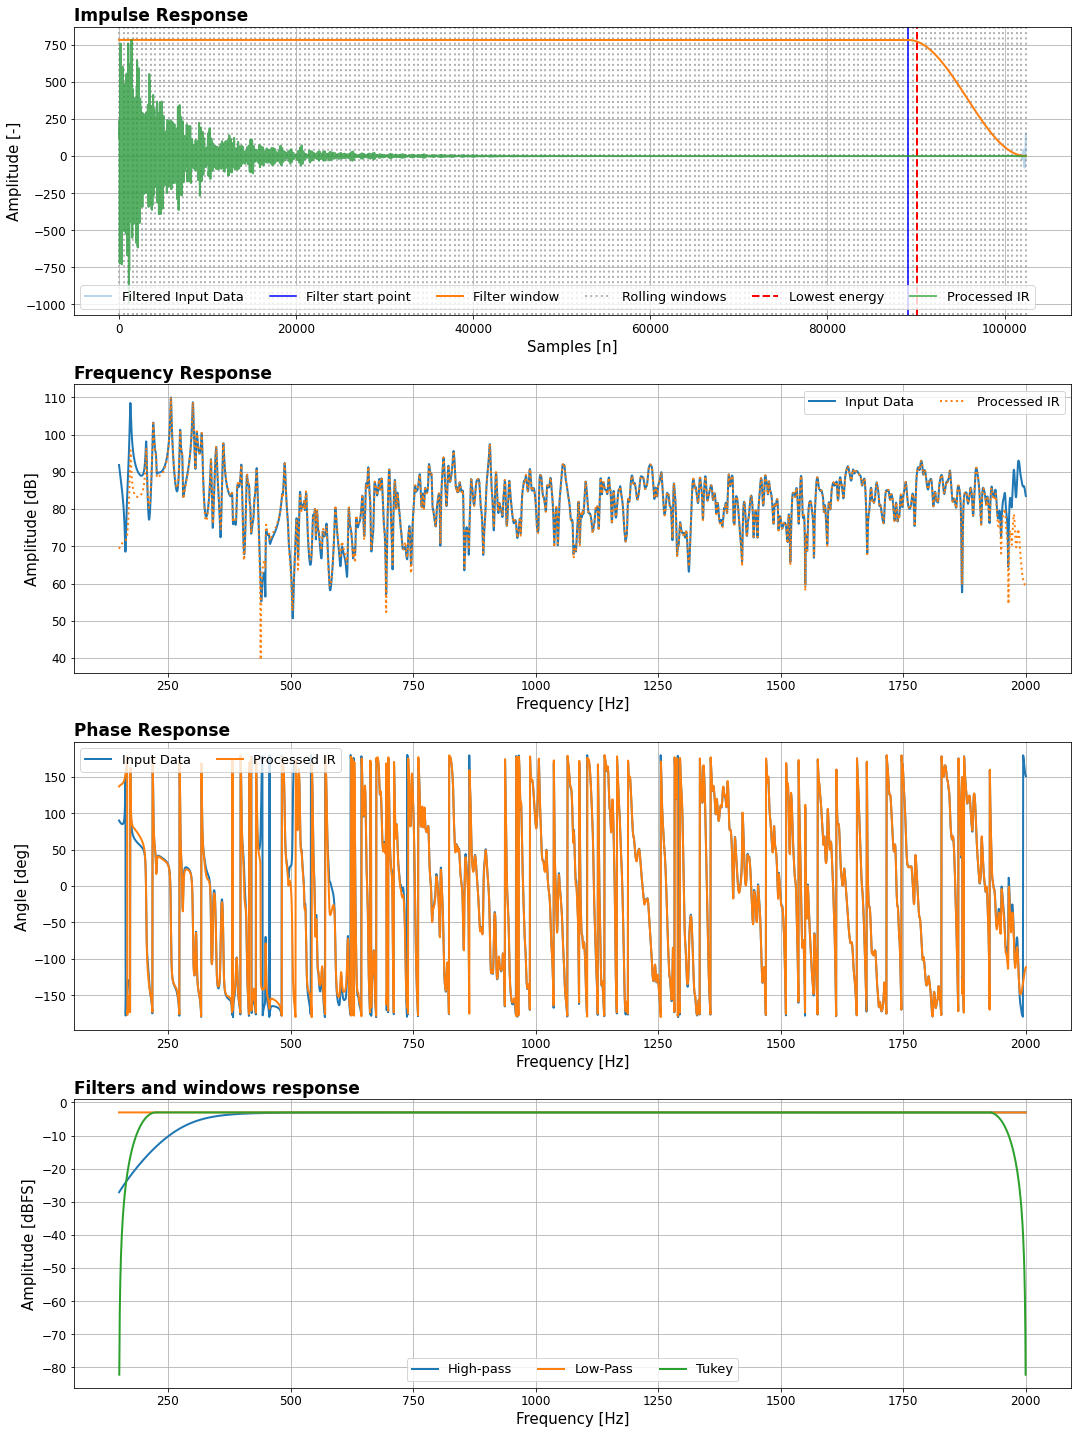

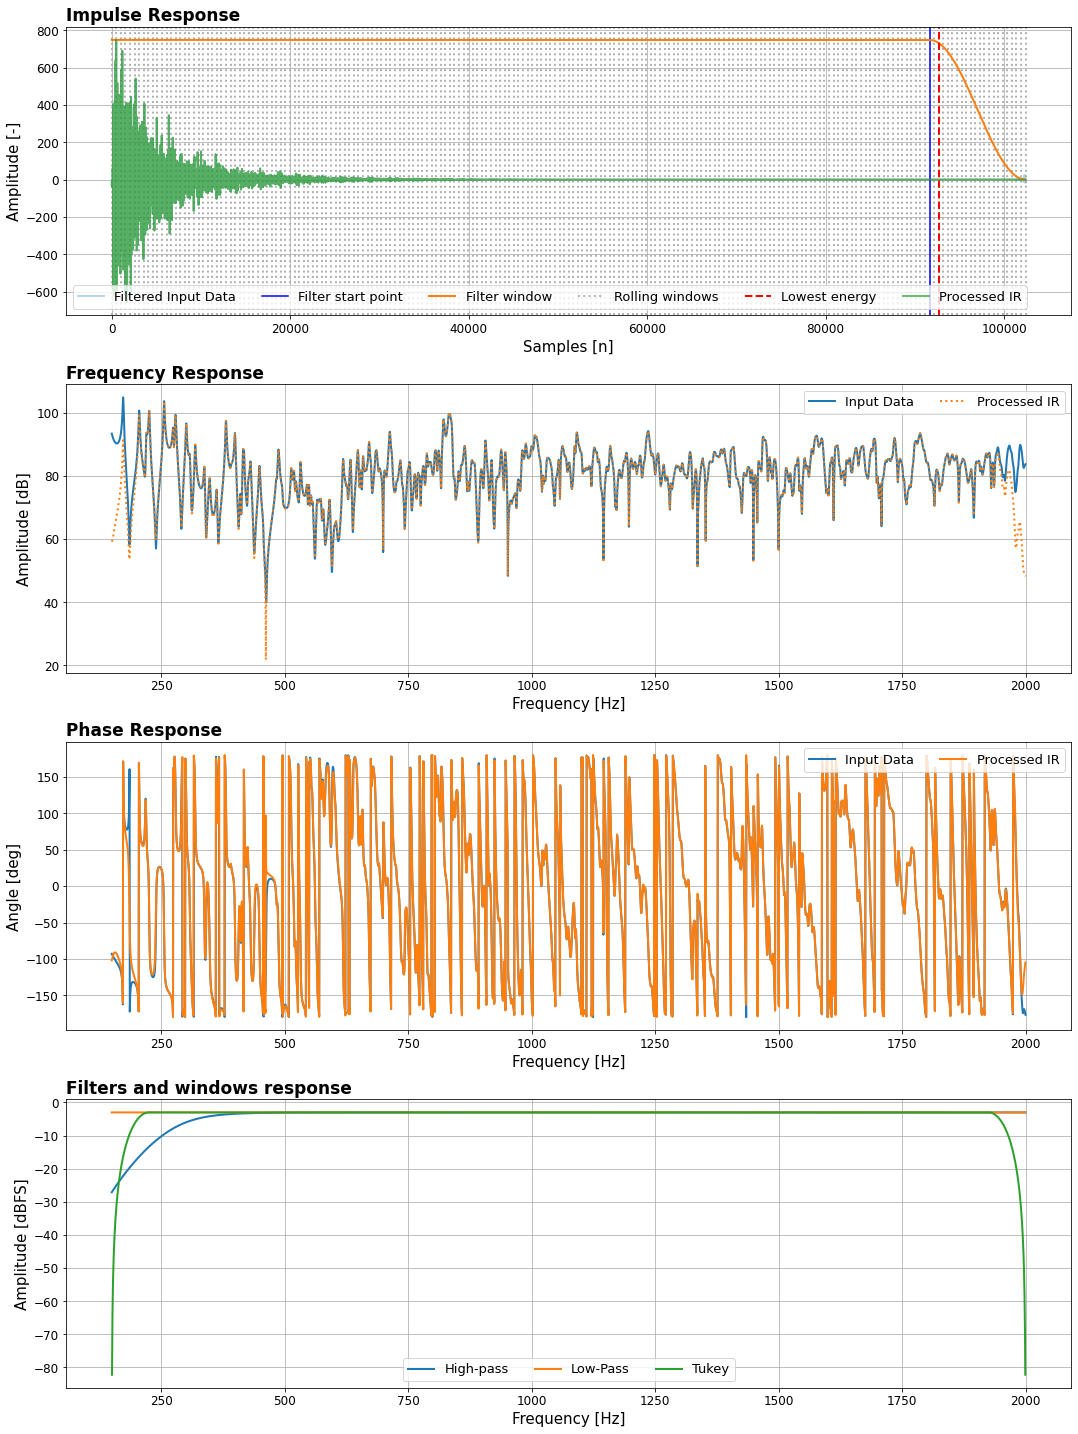

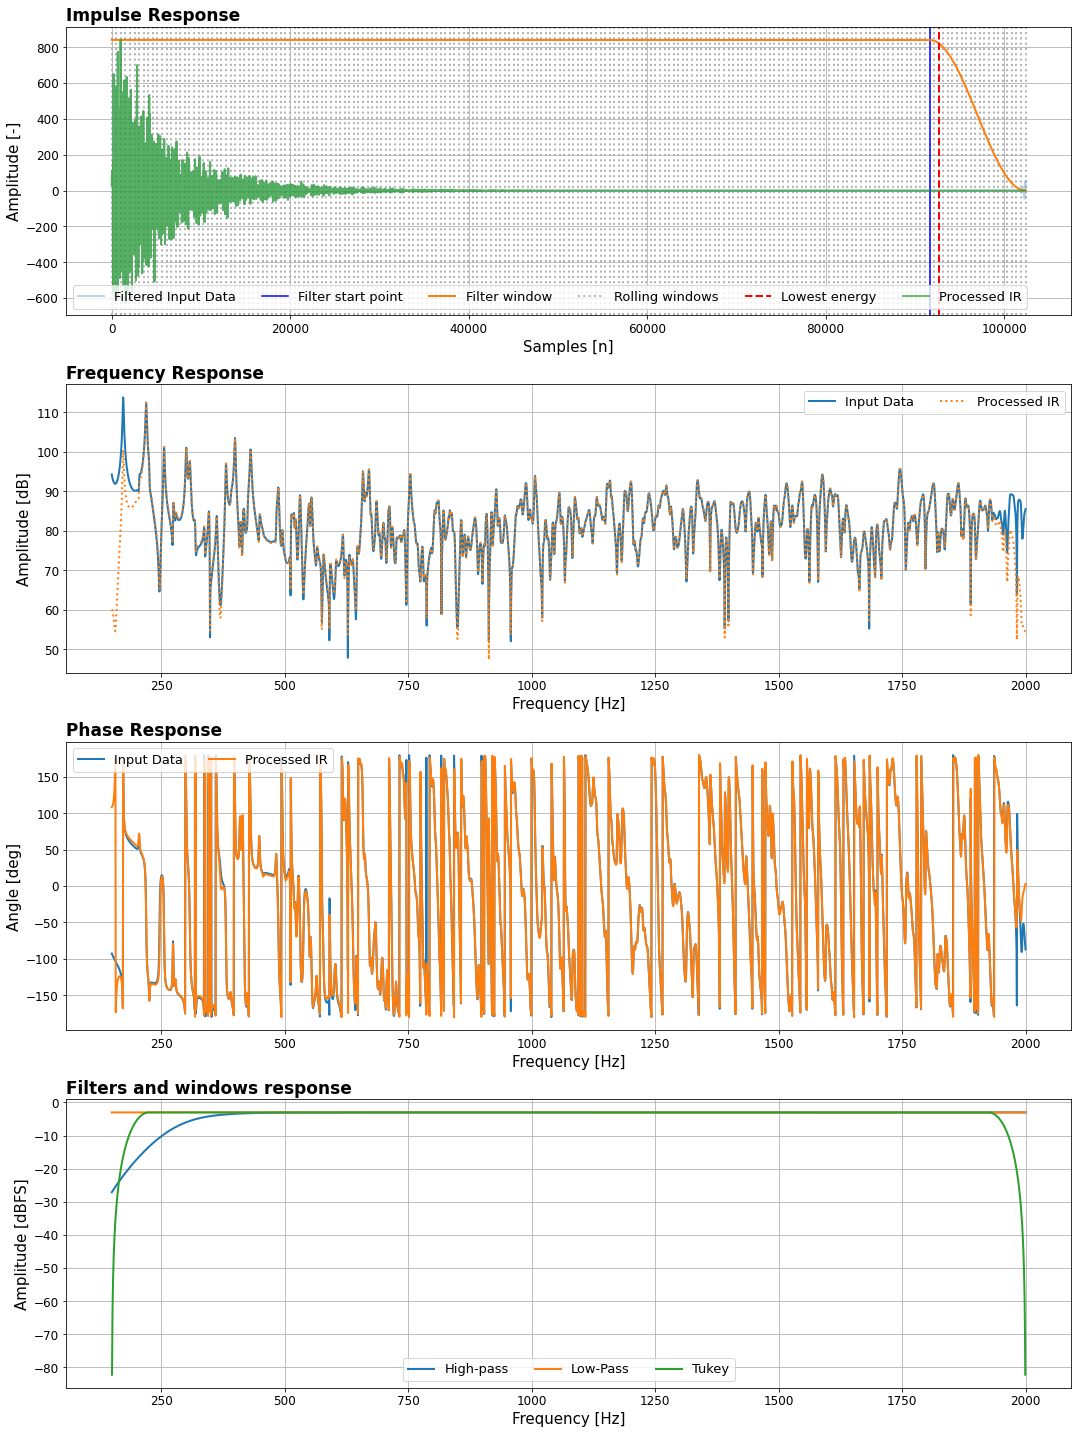

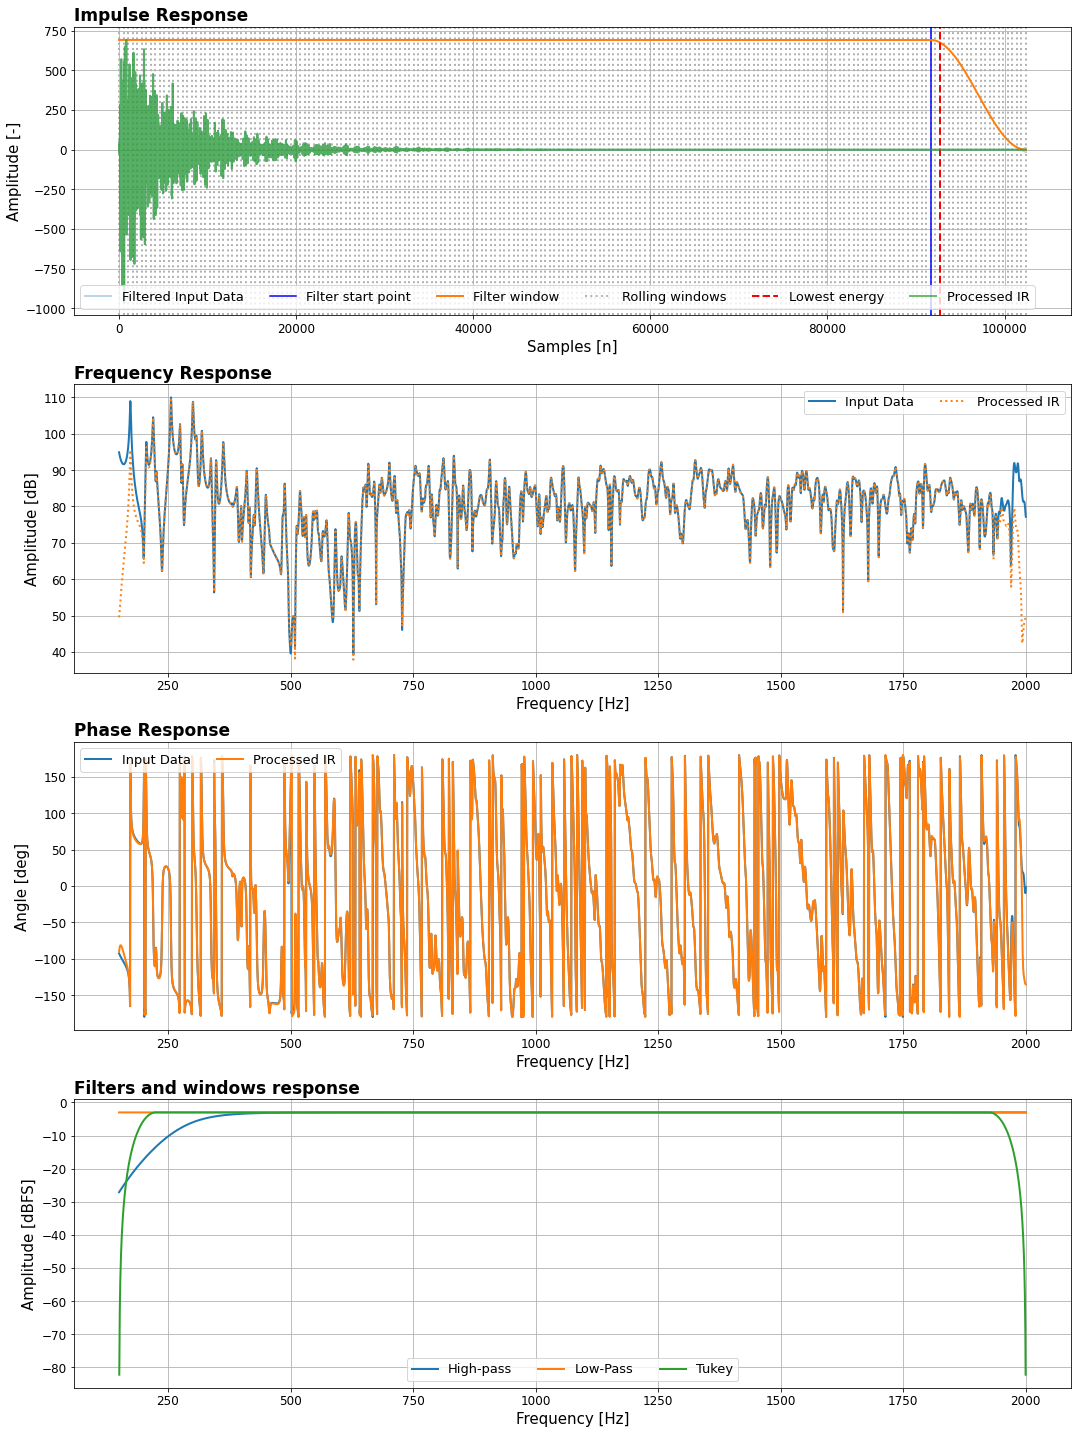

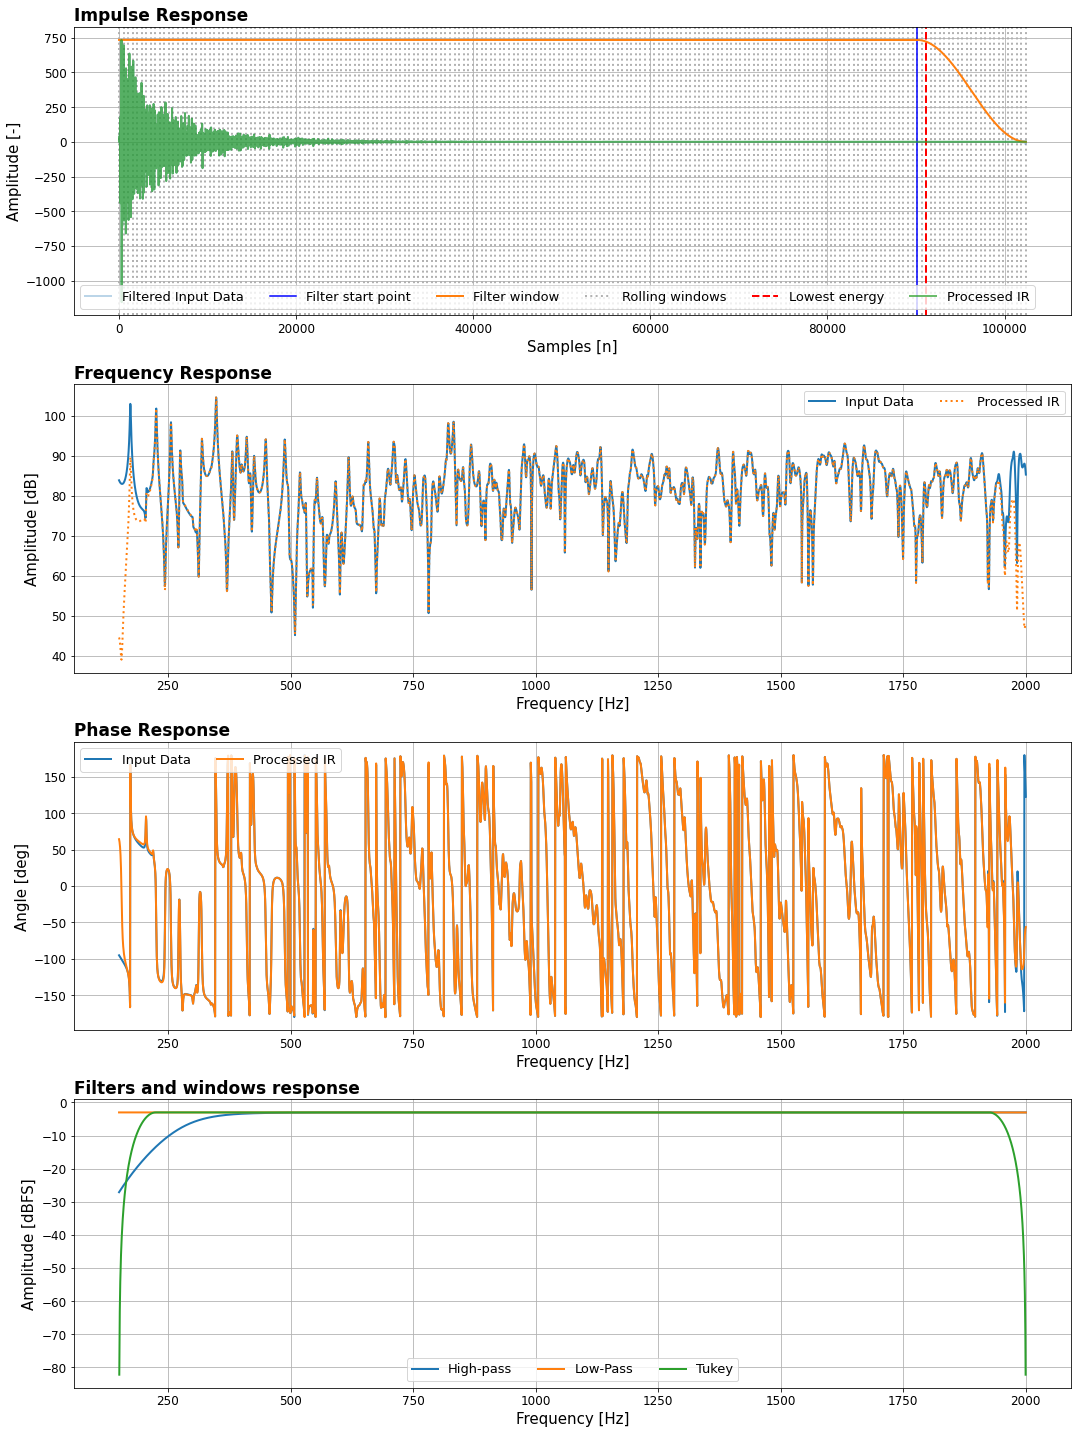

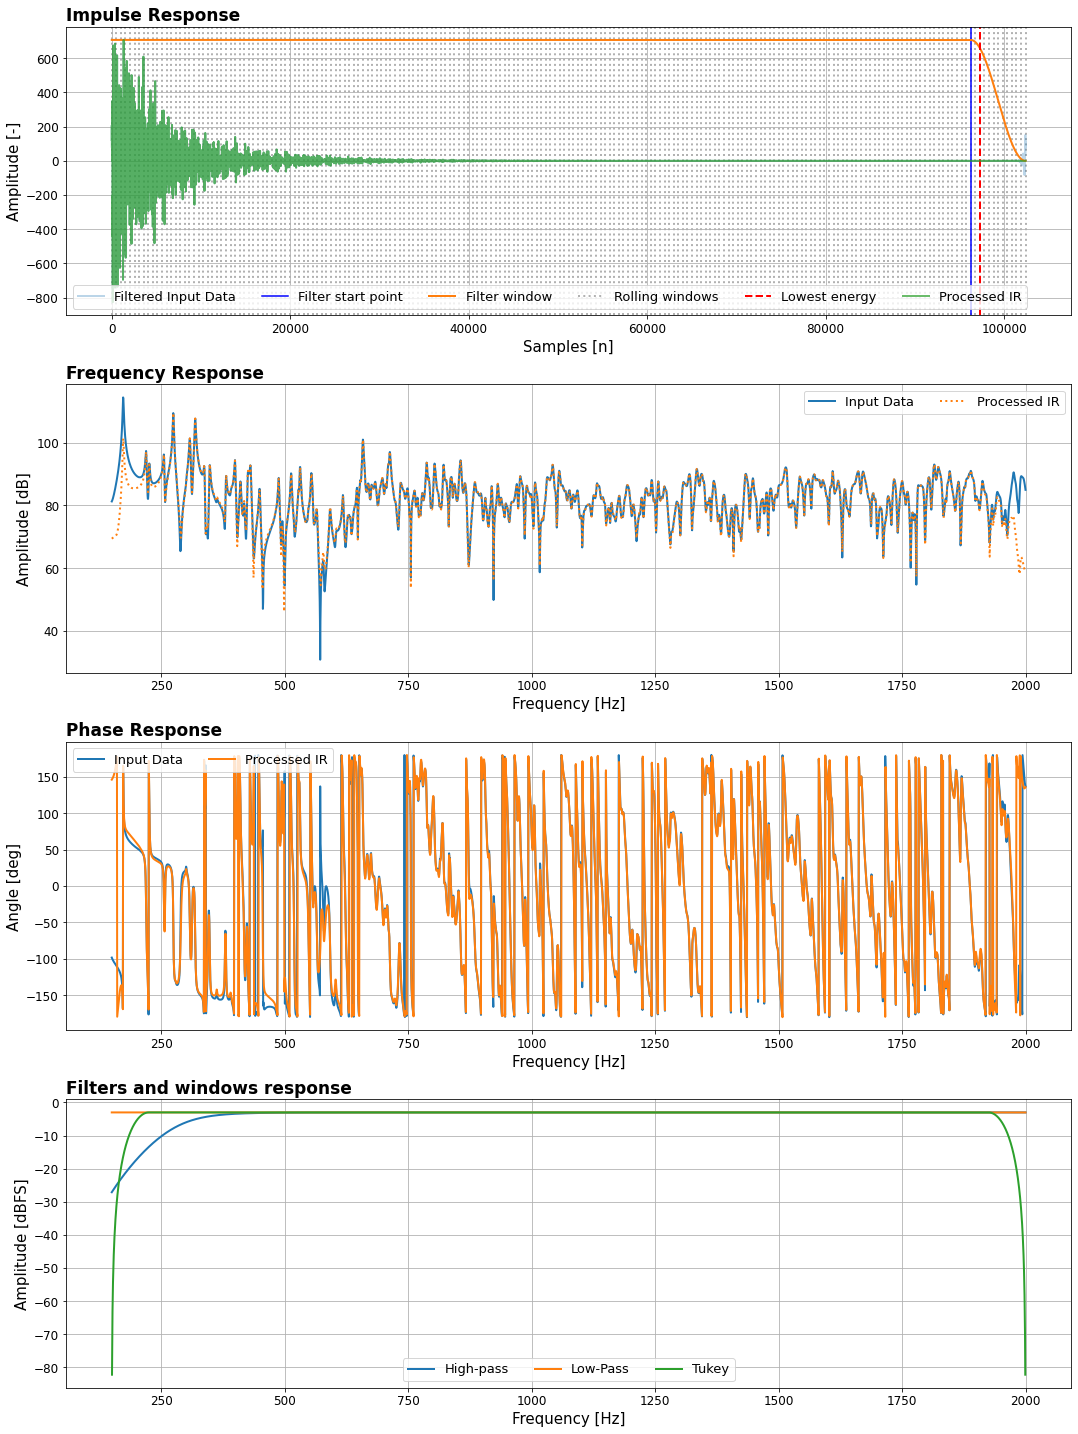

In [27]:
#%% Resposta Impulsiva
domain = fd.Domain(fmin, fmax,2,51200)
domain.alpha = 0.1
ir = np.zeros((len(RI_comMat['RIs_sz']),len(obj.pR[0,:])))
for n in range(0,len(obj.pR[0,:])):
    ir[:,n] = domain.compute_impulse_response(obj.pR[:,n], view=True, irr_filters=False)


In [28]:
# Salvar os dados p importar no MATLAB
from scipy.io import savemat
#savemat('G:\Meu Drive\TCC\Simulacao_computacional\minicamara_comMat\espessura2_5cm\Zs_DBM_cte0_004_RIs_simuladas.mat',{'RIs':ir,'freq':AC.freq})
savemat('G:\\Meu Drive\\TCC\\Simulacao_computacional\\minicamara-90mm\\minicamara_comMat\\espessura2_5cm\\Zs_DBM_cte0_004_RIs_simuladas.mat',{'RIs':ir,'freq':AC.freq})



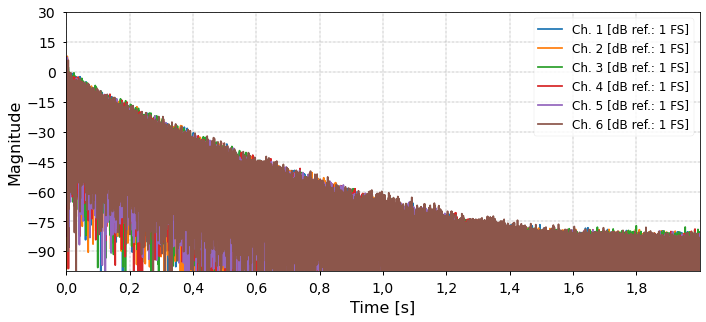

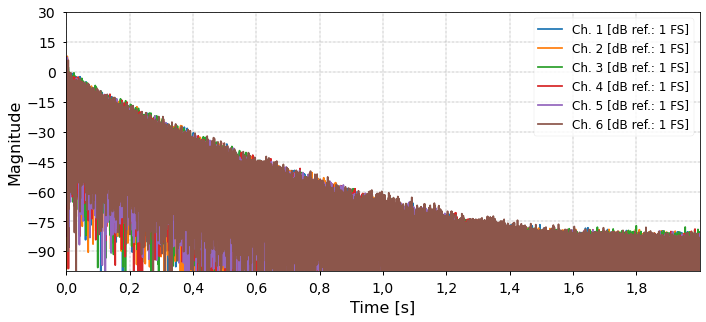

In [84]:

import pytta
txAmostragem = 51200 # [Hz]
# fftDegree = 19
# T = (2**fftDegree-1)/txAmostragem # [s]
# Cria vetor no tempo de um sinal aleatório
#meuRuido = np.random.randn(txAmostragem*T)
# SignalObj com sinal provido pelo usuário
RI_semMat = pytta.SignalObj(RI_semMat['RIs_sz'], 'time', txAmostragem) 
RI_semMat.plot_time_dB(yLim=[-100,30])

### Plote do campo de pressão

In [63]:
# Plote do campo de pressão
obj.pressure_field(frequencies = 300,renderer='browser',axis=['xy','yz'],saveFig=False,camera_angles=['diagonal_front'],extension='pdf')

G:\Meu Drive\TCC\Simulacao_computacional\codes\geo\mini-camarareverb.iges


100%|██████████| 203/203 [00:00<00:00, 2788.65it/s]



	Elapsed time to evaluate acoustic field: 0.09 minutes

